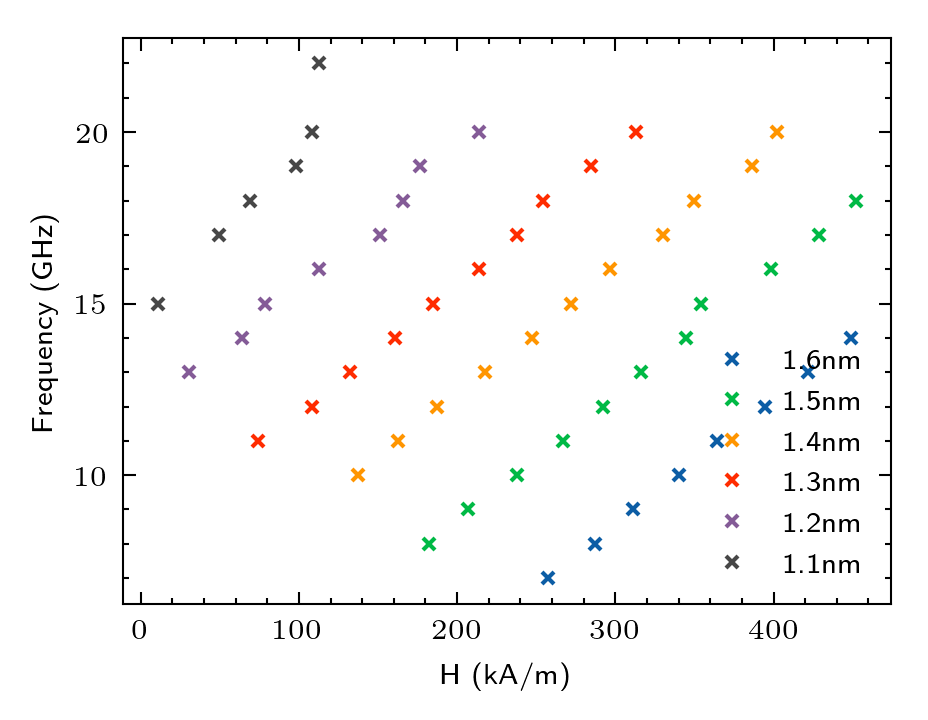

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv('export/Kittel29xx.csv', sep=';')
with plt.style.context(['science', 'nature']):

    fig, ax = plt.subplots(dpi=300)
    cols = data.columns
    for i in range(len(cols) // 2):
        ax.plot(data[cols[2 * i]] * 80 / 1e3,
                data[cols[2 * i + 1]],
                'x',
                label=cols[2 * i].replace("H_", ""))
    ax.set_ylabel('Frequency (GHz)')
    ax.set_xlabel("H (kA/m)")
    ax.legend()

# Fitting
- Resonance of the FL
- Kittel 29 -- CoFeB thickenss changes (anisotropy changes) at tMgo = 0.75nm, Ms changes (0.86 for 1 nm to 1.3 for 1.6nm)
- Kittel 56 -- MgO thickness changes (IEC changes)  at tCoFeB = 1.3nm


In [ ]:
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from cmtj.models.sb import SmitBeljersModel, VectorObj, LayerSB
from cmtj.utils import mu0, OetoAm
import json

for th in [1.6, 1.5, 1.4, 1.3, 1.2, 1.1][::-1]:
    sdf = data[[f'H_{th}nm', f'f_{th}nm']]
    sdf.dropna(inplace=True, axis=0)
    Hvector = np.asarray(sdf[f'H_{th}nm']) * OetoAm
    freqvector = np.asarray(sdf[f'f_{th}nm'])
    htheta = 90  # in plane
    hphi = 0
    fixed_ref_thickness = 0.5e-9
    Mstop = 1.0  # T

    def fmr_simulation(
        Hvector,
        Ms,
        Ks,
        Kv,
        Kphi,
        J,
    ):
        layerA = LayerSB(
            thickness=th * 1e-9,
            m=VectorObj(np.deg2rad(45), np.deg2rad(0.1)),
            Kv=VectorObj(np.deg2rad(Kphi), np.deg2rad(0), Kv),
            Ks=Ks,
            Ms=Ms / mu0,
        )
        # reference with high in plane anisotropy
        layerB = LayerSB(
            thickness=fixed_ref_thickness * 1e-9,
            m=VectorObj(np.deg2rad(90), np.deg2rad(0)),
            Kv=VectorObj(np.deg2rad(0), np.deg2rad(0), 1e6),
            Ks=0,
            Ms=Mstop / mu0,
        )
        f_spectrum = {'m1': [], 'm2': []}
        for H in Hvector:
            model = SmitBeljersModel(layers=[layerA, layerB],
                                     J=[J],
                                     D=[0],
                                     Hext=VectorObj(theta=np.deg2rad(htheta),
                                                    phi=np.deg2rad(hphi),
                                                    mag=H),
                                     silent=True)
            model.adam_gradient_descent(max_steps=1e6,
                                        tol=1e-6,
                                        learning_rate=1e-4)
            fmr1 = model.get_fmr(0, method='baselgia')
            f_spectrum['m1'].append(fmr1)
        return f_spectrum

    def loss(target, pred):
        return -1 * np.power(target - pred, 2).sum()

    def opt_fn(Ms, Ks, Kv, Kphi, J):
        f_spectrum = fmr_simulation(Hvector, Ms, Ks, Kv, Kphi, J)
        if np.iscomplex(f_spectrum['m1']).any():
            return -9e9
        fl = np.asarray(f_spectrum['m1']) / 1e9

        return loss(freqvector, fl)

    probe = {
        'Ms': (0.5, 1.8),  # T
        'Ks': (1e1, 1e6),
        'Kv': (0, 1e4),
        'Kphi': (0, 30),
        'J': (-5e-4, 5e-4),
    }
    optimiser = BayesianOptimization(
        f=opt_fn,
        pbounds=probe,
        random_state=42,
        bounds_transformer=SequentialDomainReductionTransformer())
    optimiser.probe(params={
        'Ms': 0.5,
        'Ks': 1e3,
        'Kv': 1e3,
        'Kphi': 0,
        'J': 1e-6,
    },
                    lazy=True)
    try:
        optimiser.maximize(init_points=60, n_iter=300)
    except KeyboardInterrupt:
        print("Best target:", optimiser.max)

    fspectrum = fmr_simulation(
        Hvector,
        **optimiser.max['params'],
    )
    with plt.style.context(['science', 'nature']):
        fig, ax = plt.subplots(1, 1, dpi=300)
        ax.plot(Hvector, freqvector, 'o', color='royalblue', label='data')
        ax.plot(Hvector,
                np.asarray(fspectrum['m1']) / 1e9,
                'x-',
                color='crimson',
                label='fit')
        ax.set_xlabel('Field [kOe]')
        ax.set_ylabel('Frequency [GHz]')
        ax.set_title(
            f"fit error: {loss(freqvector, np.asarray(fspectrum['m1'])/1e9):.2f}"
        )
        ax.legend()
        fig.savefig(f'optim_{th}nm.png')
        json.dump(optimiser.max['params'], open(f'optim_{th}nm.json', 'w'))